In [ ]:
!pip install pytorch-tabnet

In [ ]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier

In [ ]:
#Membaca dataset
df = pd.read_excel("PPG-BP dataset.xlsx", header=1)

In [ ]:
# Lihat data awal
print(df.head(), "\n")

   Num.  subject_ID Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  \
0     1           2   Female         45         152          63   
1     2           3   Female         50         157          50   
2     3           6   Female         47         150          47   
3     4           8     Male         45         172          65   
4     5           9   Female         46         155          65   

   Systolic Blood Pressure(mmHg)  Diastolic Blood Pressure(mmHg)  \
0                            161                              89   
1                            160                              93   
2                            101                              71   
3                            136                              93   
4                            123                              73   

   Heart Rate(b/m)  BMI(kg/m^2)          Hypertension Diabetes  \
0               97    27.268006  Stage 2 hypertension      NaN   
1               76    20.284799  Stage 2 hypertension   

In [ ]:
#informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Num.                            219 non-null    int64  
 1   subject_ID                      219 non-null    int64  
 2   Sex(M/F)                        219 non-null    object 
 3   Age(year)                       219 non-null    int64  
 4   Height(cm)                      219 non-null    int64  
 5   Weight(kg)                      219 non-null    int64  
 6   Systolic Blood Pressure(mmHg)   219 non-null    int64  
 7   Diastolic Blood Pressure(mmHg)  219 non-null    int64  
 8   Heart Rate(b/m)                 219 non-null    int64  
 9   BMI(kg/m^2)                     219 non-null    float64
 10  Hypertension                    219 non-null    object 
 11  Diabetes                        38 non-null     object 
 12  cerebral infarction             20 n

In [ ]:
# Cek jumlah missing values
print(df.isnull().sum())

Num.                                0
subject_ID                          0
Sex(M/F)                            0
Age(year)                           0
Height(cm)                          0
Weight(kg)                          0
Systolic Blood Pressure(mmHg)       0
Diastolic Blood Pressure(mmHg)      0
Heart Rate(b/m)                     0
BMI(kg/m^2)                         0
Hypertension                        0
Diabetes                          181
cerebral infarction               199
cerebrovascular disease           194
dtype: int64


In [ ]:
# Hapus kolom tidak relevan
if 'Num.' in df.columns:
    df.drop('Num.', axis=1, inplace=True)
if 'subject_ID' in df.columns:
    df.drop('subject_ID', axis=1, inplace=True)

In [ ]:
# Isi nilai kosong pada kolom kategorikal dengan 'Unknown'
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Unknown')

# Isi nilai kosong pada kolom numerik dengan median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

In [ ]:
# Hapus data duplikat
print("\nJumlah duplikasi:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


Jumlah duplikasi: 0


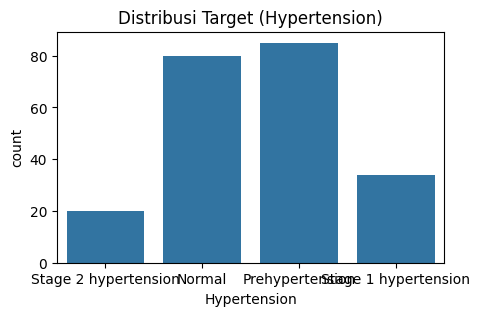

In [ ]:
#Visualisasi distribusi target

plt.figure(figsize=(5, 3))
sns.countplot(x='Hypertension', data=df)
plt.title("Distribusi Target (Hypertension)")
plt.show()

In [ ]:
#Encoding untuk kolom kategorikal
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

print("\n Data setelah encoding:")
print(df.head())


 Data setelah encoding:
   Sex(M/F)  Age(year)  Height(cm)  Weight(kg)  Systolic Blood Pressure(mmHg)  \
0         0         45         152          63                            161   
1         0         50         157          50                            160   
2         0         47         150          47                            101   
3         1         45         172          65                            136   
4         0         46         155          65                            123   

   Diastolic Blood Pressure(mmHg)  Heart Rate(b/m)  BMI(kg/m^2)  Hypertension  \
0                              89               97    27.268006             3   
1                              93               76    20.284799             3   
2                              71               79    20.888889             0   
3                              93               87    21.971336             1   
4                              73               73    27.055151             1   

 

In [ ]:
# Pisahkan fitur dan target
X = df.drop('Hypertension', axis=1)
y = df['Hypertension']

# Cek distribusi target sebelum SMOTE
print("\nDistribusi target sebelum SMOTE:")
print(y.value_counts())


Distribusi target sebelum SMOTE:
Hypertension
1    85
0    80
2    34
3    20
Name: count, dtype: int64


In [ ]:
#SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print("\nDistribusi target setelah SMOTE:")
print(y_res.value_counts())


Distribusi target setelah SMOTE:
Hypertension
3    85
0    85
1    85
2    85
Name: count, dtype: int64


In [ ]:
#Split data menjadi train & test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

# Normalisasi fitur numerik
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

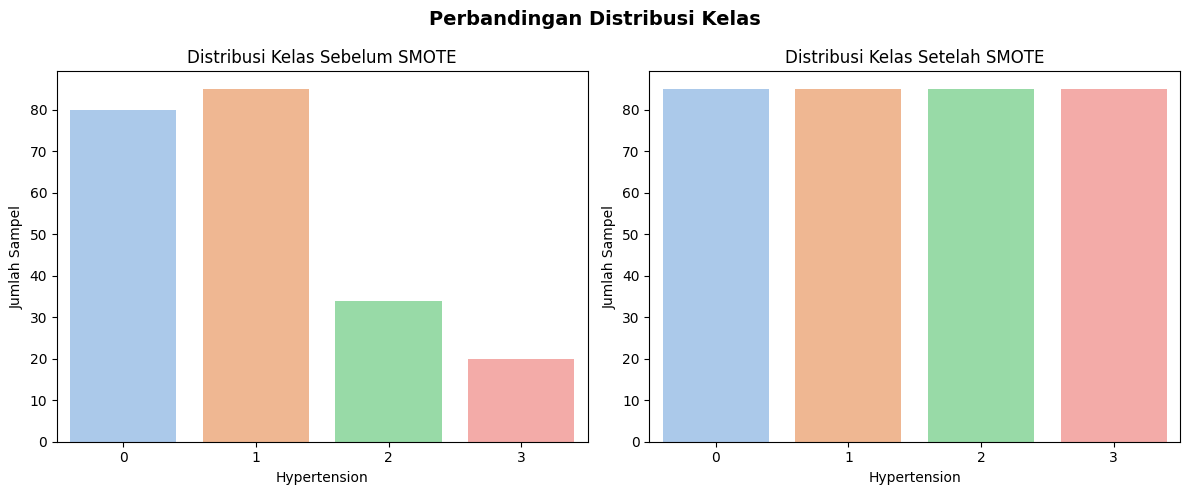

In [ ]:
# Visualisasi Distribusi Kelas Sebelum & Sesudah SMOTE=
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Sebelum SMOTE
sns.countplot(x=y, hue=y, ax=axs[0], palette="pastel", legend=False)
axs[0].set_title("Distribusi Kelas Sebelum SMOTE")
axs[0].set_xlabel("Hypertension")
axs[0].set_ylabel("Jumlah Sampel")

# Sesudah SMOTE
sns.countplot(x=y_res, hue=y_res, ax=axs[1], palette="pastel", legend=False)
axs[1].set_title("Distribusi Kelas Setelah SMOTE")
axs[1].set_xlabel("Hypertension")
axs[1].set_ylabel("Jumlah Sampel")

plt.suptitle("Perbandingan Distribusi Kelas", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Konversi ke numpy array (TabNet)
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [ ]:
#TabNet belajar dari data hasil SMOTE
print("Melatih TabNet dengan data hasil SMOTE")
tabnet = TabNetClassifier(
    n_d=8, n_a=8, n_steps=3,
    gamma=1.3,
    n_independent=2, n_shared=2,
    momentum=0.02,
    seed=42,
    verbose=10
)

start = time.time()
tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_test_np, y_test_np)],
    eval_name=['test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=15,
    batch_size=64,
    virtual_batch_size=32
)
tabnet_time = time.time() - start

print(f"\nTabNet selesai dilatih dalam {tabnet_time:.2f} detik")

Melatih TabNet dengan data hasil SMOTE
epoch 0  | loss: 1.82018 | test_accuracy: 0.33824 |  0:00:00s


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 10 | loss: 0.56289 | test_accuracy: 0.75    |  0:00:01s
epoch 20 | loss: 0.33437 | test_accuracy: 0.85294 |  0:00:03s
epoch 30 | loss: 0.29696 | test_accuracy: 0.86765 |  0:00:06s
epoch 40 | loss: 0.31204 | test_accuracy: 0.89706 |  0:00:08s
epoch 50 | loss: 0.2564  | test_accuracy: 0.94118 |  0:00:12s
epoch 60 | loss: 0.3289  | test_accuracy: 0.92647 |  0:00:14s

Early stopping occurred at epoch 68 with best_epoch = 53 and best_test_accuracy = 0.97059

TabNet selesai dilatih dalam 16.77 detik


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
#Ambil representasi fitur dari TabNet
print("\nMengambil representasi fitur dari TabNet")

# Akses network internal (model PyTorch di dalam TabNetClassifier)
tabnet.network.eval()

X_train_tensor = torch.tensor(X_train_np).float()
X_test_tensor = torch.tensor(X_test_np).float()

with torch.no_grad():
    # TabNet menghasilkan tuple: (output_prediksi, output_mask)
    embedded_train, _ = tabnet.network(X_train_tensor)
    embedded_test, _ = tabnet.network(X_test_tensor)

X_train_emb = embedded_train.detach().cpu().numpy()
X_test_emb = embedded_test.detach().cpu().numpy()

print("Bentuk fitur baru dari TabNet:", X_train_emb.shape)


Mengambil representasi fitur dari TabNet
Bentuk fitur baru dari TabNet: (272, 4)


In [ ]:
# Prediksi
y_pred_tabnet = tabnet.predict(X_test_np)

print(f"\nAkurasi TabNet: {accuracy_score(y_test_np, y_pred_tabnet):.4f}")
print(f"Waktu pelatihan: {tabnet_time:.4f} detik")
print("\nLaporan klasifikasi:")
print(classification_report(y_test_np, y_pred_tabnet))


Akurasi TabNet: 0.9706
Waktu pelatihan: 16.7658 detik

Laporan klasifikasi:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.91      0.95        23
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00        21

    accuracy                           0.97        68
   macro avg       0.96      0.98      0.97        68
weighted avg       0.97      0.97      0.97        68



In [ ]:
# Model 1: Naive Bayes
print("\nModel: Naive Bayes (Fitur TabNet)")
nb = GaussianNB()

start = time.time()
nb.fit(X_train_emb, y_train_np)
nb_time = time.time() - start

y_pred_nb = nb.predict(X_test_emb)


Model: Naive Bayes (Fitur TabNet)


Akurasi: 0.9559
Waktu pelatihan: 0.0057 detik
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.96      0.96      0.96        23
           2       0.91      0.91      0.91        11
           3       1.00      0.95      0.98        21

    accuracy                           0.96        68
   macro avg       0.95      0.95      0.95        68
weighted avg       0.96      0.96      0.96        68



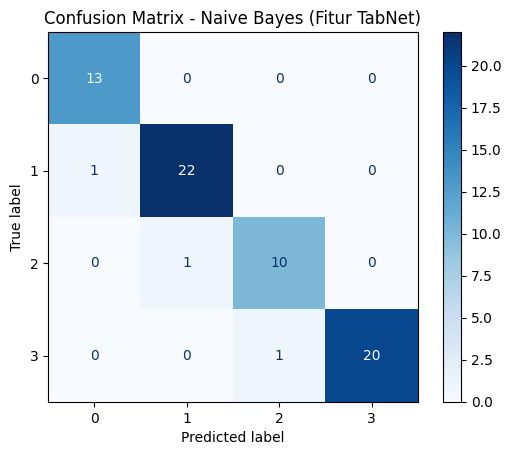

In [ ]:
print(f"Akurasi: {accuracy_score(y_test_np, y_pred_nb):.4f}")
print(f"Waktu pelatihan: {nb_time:.4f} detik")
print(classification_report(y_test_np, y_pred_nb))

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_nb, cmap='Blues')
plt.title("Confusion Matrix - Naive Bayes (Fitur TabNet)")
plt.show()

In [ ]:
# Model 2: SVM
print("\nModel: Support Vector Machine (Fitur TabNet)")
svm = SVC(kernel='rbf', probability=True)

start = time.time()
svm.fit(X_train_emb, y_train_np)
svm_time = time.time() - start

y_pred_svm = svm.predict(X_test_emb)


Model: Support Vector Machine (Fitur TabNet)


Akurasi: 0.9706
Waktu pelatihan: 0.0179 detik
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.96      0.96      0.96        23
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        21

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



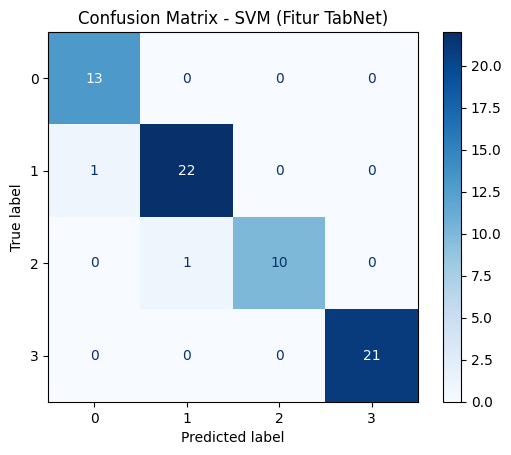

In [ ]:
print(f"Akurasi: {accuracy_score(y_test_np, y_pred_svm):.4f}")
print(f"Waktu pelatihan: {svm_time:.4f} detik")
print(classification_report(y_test_np, y_pred_svm))

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_svm, cmap='Blues')
plt.title("Confusion Matrix - SVM (Fitur TabNet)")
plt.show()

In [ ]:
# Model 3: Decision Tree
print("\nModel: Decision Tree (Fitur TabNet)")
dt = DecisionTreeClassifier(random_state=42)

start = time.time()
dt.fit(X_train_emb, y_train_np)
dt_time = time.time() - start

y_pred_dt = dt.predict(X_test_emb)


Model: Decision Tree (Fitur TabNet)


Akurasi: 0.8971
Waktu pelatihan: 0.0101 detik
              precision    recall  f1-score   support

           0       0.80      0.92      0.86        13
           1       0.90      0.83      0.86        23
           2       0.90      0.82      0.86        11
           3       0.95      1.00      0.98        21

    accuracy                           0.90        68
   macro avg       0.89      0.89      0.89        68
weighted avg       0.90      0.90      0.90        68



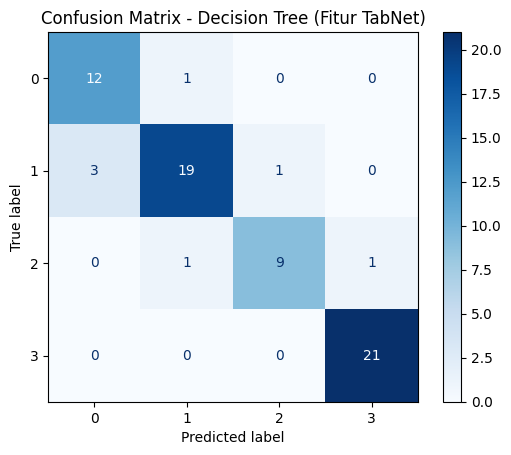

In [ ]:
print(f"Akurasi: {accuracy_score(y_test_np, y_pred_dt):.4f}")
print(f"Waktu pelatihan: {dt_time:.4f} detik")
print(classification_report(y_test_np, y_pred_dt))

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_dt, cmap='Blues')
plt.title("Confusion Matrix - Decision Tree (Fitur TabNet)")
plt.show()

In [ ]:
# Model 4: K-Nearest Neighbors
print("\nModel: K-Nearest Neighbors (Fitur TabNet)")
knn = KNeighborsClassifier(n_neighbors=5)

start = time.time()
knn.fit(X_train_emb, y_train_np)
knn_time = time.time() - start

y_pred_knn = knn.predict(X_test_emb)


Model: K-Nearest Neighbors (Fitur TabNet)


Akurasi: 0.9706
Waktu pelatihan: 0.0065 detik
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.96      0.96      0.96        23
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        21

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



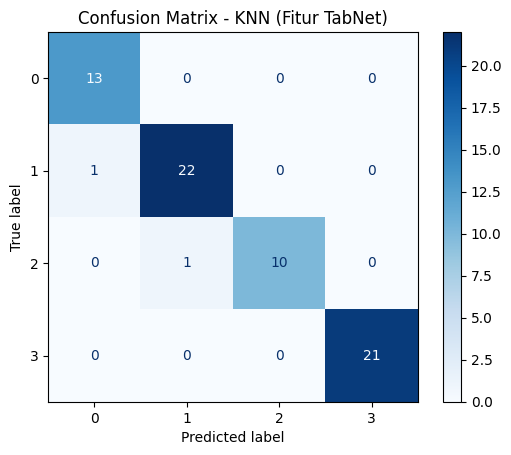

In [ ]:
print(f"Akurasi: {accuracy_score(y_test_np, y_pred_knn):.4f}")
print(f"Waktu pelatihan: {knn_time:.4f} detik")
print(classification_report(y_test_np, y_pred_knn))

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_knn, cmap='Blues')
plt.title("Confusion Matrix - KNN (Fitur TabNet)")
plt.show()

In [ ]:
# Model 5: Random Forest
print("\nModel: Random Forest (Fitur TabNet)")
rf = RandomForestClassifier(random_state=42, n_estimators=100)

start = time.time()
rf.fit(X_train_emb, y_train_np)
rf_time = time.time() - start

y_pred_rf = rf.predict(X_test_emb)


Model: Random Forest (Fitur TabNet)


Akurasi: 0.9706
Waktu pelatihan: 0.3470 detik
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       0.96      0.96      0.96        23
           2       1.00      0.91      0.95        11
           3       1.00      1.00      1.00        21

    accuracy                           0.97        68
   macro avg       0.97      0.97      0.97        68
weighted avg       0.97      0.97      0.97        68



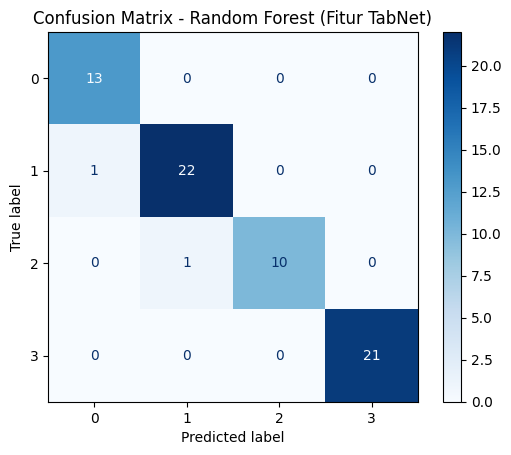

In [ ]:
print(f"Akurasi: {accuracy_score(y_test_np, y_pred_rf):.4f}")
print(f"Waktu pelatihan: {rf_time:.4f} detik")
print(classification_report(y_test_np, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test_np, y_pred_rf, cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Fitur TabNet)")
plt.show()

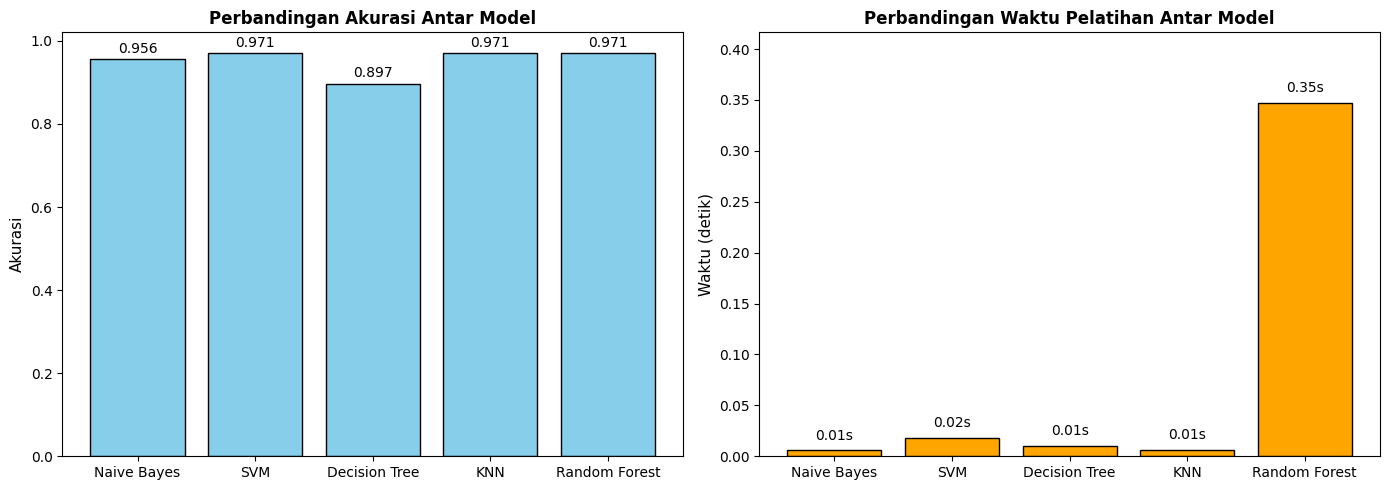

In [ ]:
#Visualisasi Perbandingan Akurasi dan Waktu Pelatihan

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

#Daftar model dan hasilnya
model_names = ['Naive Bayes', 'SVM', 'Decision Tree', 'KNN', 'Random Forest']

accuracies = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_knn),
    accuracy_score(y_test, y_pred_rf)
]

train_times = [nb_time, svm_time, dt_time, knn_time, rf_time]

#Membuat dua subplot (akurasi & waktu)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Grafik Akurasi
ax[0].bar(model_names, accuracies, color='skyblue', edgecolor='black')
ax[0].set_title("Perbandingan Akurasi Antar Model", fontsize=12, fontweight='bold')
ax[0].set_ylabel("Akurasi", fontsize=11)
ax[0].set_ylim(0, 1)

max_acc = max(accuracies)
ax[0].set_ylim(0, min(1.05, max_acc + 0.05))

for i, v in enumerate(accuracies):
    ax[0].text(i, v + 0.015, f"{v:.3f}", ha='center', fontsize=10)

#Grafik Waktu Pelatihan
ax[1].bar(model_names, train_times, color='orange', edgecolor='black')
ax[1].set_title("Perbandingan Waktu Pelatihan Antar Model", fontsize=12, fontweight='bold')
ax[1].set_ylabel("Waktu (detik)", fontsize=11)

max_time = max(train_times)
ax[1].set_ylim(0, max_time * 1.2)

for i, v in enumerate(train_times):
    ax[1].text(i, v + (max_time * 0.03), f"{v:.2f}s", ha='center', fontsize=10)

plt.tight_layout()
plt.show()